<a href="https://colab.research.google.com/github/abrahamsteep90/NLP-PoemGenerator/blob/main/NLP-PoemGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 13s (33.4 MB/s)
(Reading database ... 155569 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155547 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+

In [9]:
import gdown
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

In [30]:
#FG_Poems.txt
url = "https://drive.google.com/uc?export=download&id=11Gmcm7PS8cJlz84qkPwazfFvUYLAv6h3"
output = "FG_Poems.txt"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=11Gmcm7PS8cJlz84qkPwazfFvUYLAv6h3
To: /content/FG_Poems.txt
100%|██████████| 55.5k/55.5k [00:00<00:00, 44.5MB/s]


'FG_Poems.txt'

In [31]:
# Define path for file with sonnets
FG_FILE = './FG_Poems.txt'

# Read the data
with open('./FG_Poems.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of Gulen Poems\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 1380 lines of Gulen Poems

The first 5 lines look like this:

şafak çoktan söktü, ufukta ışık cümbüşü,
zulmetler hırıltıda, soluk soluğa nûrlar.
çözülüyor bir bir ufkumdaki sis ve duman,
her yanda zümrüt saçlarıyla o yeni bahar...
yollarda bir nesil var, sanki fetih ordusu,


In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [33]:
# n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
    return input_sequences

In [34]:
# Testing with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[94, 202],
 [94, 202, 1111],
 [94, 202, 1111, 61],
 [94, 202, 1111, 61, 62],
 [94, 202, 1111, 61, 62, 1112]]

In [35]:
# Testing with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[326, 1113],
 [326, 1113, 327],
 [326, 1113, 327, 540],
 [326, 1113, 327, 540, 95],
 [541, 1],
 [541, 1, 1],
 [541, 1, 1, 1114],
 [541, 1, 1, 1114, 203],
 [541, 1, 1, 1114, 203, 3],
 [541, 1, 1, 1114, 203, 3, 204],
 [2, 31],
 [2, 31, 155],
 [2, 31, 155, 1115],
 [2, 31, 155, 1115, 5],
 [2, 31, 155, 1115, 5, 156],
 [2, 31, 155, 1115, 5, 156, 13]]

In [36]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 5715
maximum length of sequences is: 9


In [37]:
#pad_seqs
def pad_seqs(input_sequences, maxlen):
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen = maxlen, padding ='pre'))
    return padded_sequences


In [38]:
# Testing with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[   0,    0,    0,   94,  202],
       [   0,    0,   94,  202, 1111],
       [   0,   94,  202, 1111,   61],
       [  94,  202, 1111,   61,   62],
       [ 202, 1111,   61,   62, 1112]], dtype=int32)

In [39]:
# Testing with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,  326, 1113],
       [   0,    0,    0,    0,  326, 1113,  327],
       [   0,    0,    0,  326, 1113,  327,  540],
       [   0,    0,  326, 1113,  327,  540,   95],
       [   0,    0,    0,    0,    0,  541,    1],
       [   0,    0,    0,    0,  541,    1,    1],
       [   0,    0,    0,  541,    1,    1, 1114],
       [   0,    0,  541,    1,    1, 1114,  203],
       [   0,  541,    1,    1, 1114,  203,    3],
       [ 541,    1,    1, 1114,  203,    3,  204],
       [   0,    0,    0,    0,    0,    2,   31],
       [   0,    0,    0,    0,    2,   31,  155],
       [   0,    0,    0,    2,   31,  155, 1115],
       [   0,    0,    2,   31,  155, 1115,    5],
       [   0,    2,   31,  155, 1115,    5,  156],
       [   2,   31,  155, 1115,    5,  156,   13]], dtype=int32)

In [40]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (5715, 9)


In [41]:
#features_and_labels
def features_and_labels(input_sequences, total_words):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes = total_words)
    return features, one_hot_labels

In [42]:
# Testing with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3442)

features look like this:



array([[   0,    0,    0,   94],
       [   0,    0,   94,  202],
       [   0,   94,  202, 1111],
       [  94,  202, 1111,   61],
       [ 202, 1111,   61,   62]], dtype=int32)

In [43]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (5715, 8)
labels have shape: (5715, 3442)


In [53]:
#create_model
def create_model(total_words, max_sequence_len):
    model = Sequential([
          Embedding(total_words, 100, input_length=max_sequence_len-1),
          Bidirectional(LSTM(300)),
          Dense(total_words, activation='softmax')
          ])
    
    # Compile the model
    model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

    return model

In [54]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
179/179 [==============================] - 21s 95ms/step - loss: 7.9927 - accuracy: 0.0355
Epoch 2/50
179/179 [==============================] - 17s 95ms/step - loss: 7.4822 - accuracy: 0.0362
Epoch 3/50
179/179 [==============================] - 18s 100ms/step - loss: 7.1899 - accuracy: 0.0373
Epoch 4/50
179/179 [==============================] - 17s 94ms/step - loss: 6.7877 - accuracy: 0.0420
Epoch 5/50
179/179 [==============================] - 17s 93ms/step - loss: 6.1770 - accuracy: 0.0551
Epoch 6/50
179/179 [==============================] - 17s 94ms/step - loss: 5.3730 - accuracy: 0.0887
Epoch 7/50
179/179 [==============================] - 17s 94ms/step - loss: 4.3824 - accuracy: 0.1552
Epoch 8/50
179/179 [==============================] - 17s 95ms/step - loss: 3.3818 - accuracy: 0.2807
Epoch 9/50
179/179 [==============================] - 17s 94ms/step - loss: 2.4789 - accuracy: 0.4446
Epoch 10/50
179/179 [==============================] - 17s 94ms/step - loss: 1.77

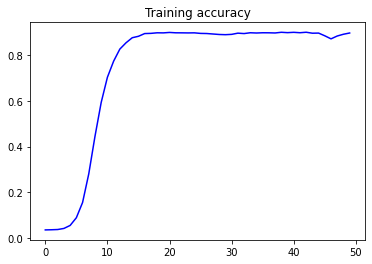

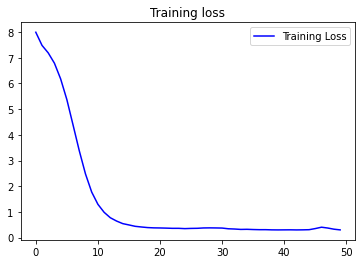

In [55]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

In [79]:
# Define seed text
seed_text = "Al beni terkine, al ey kahraman, Gidelim, mahmuzla atı, yâre sür"

# Define total words to predict
next_words = 50

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

Al beni terkine, al ey kahraman, Gidelim, mahmuzla atı, yâre sür beni kan bunaldım ağlayalım gergin güneşler azap emeli sıkılsın var dudaklarda işler eremezsin hazan ağarıyor bağlar eremezsin eremezsin mest toprak yerlerde hendese kebâp mest değer gerek yollar şenlikler ötelere efsâneler bir çözülüyor bir ilerde güneşler haz asırlık acısı güneşlerin çağları kol gezen güneşler sular güneşler kimler dinler felekler imiş çağları
